In [331]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import scipy
import sklearn
import lightgbm as lgb


In [258]:
pd.options.display.max_columns = 100

In [360]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [260]:
target_name = 'SalePrice'
target = train_df[target_name]

#### Пропущенные признаки
Пропущенные признаки обнаружены в столбцах ниже. Так как данные представляют собой отдельные записи интерполяция значений не представляется хорошим вариантом. Наличие столбцов в которых non-null значений представляет большой объем говорит о том что удаление строк содержащих Null значения не представляется хорошей идеей. До оценки важности признаков изменений не вношу.

In [261]:
columns_with_miss = train_df.columns[train_df.isna().any(axis = 0)]
train_df[columns_with_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

#### Обозначим категориальные, бинарные, вещественные и временные признаки

In [262]:
float_columns = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'TotRmsAbvGrd' , 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

categorical_columns = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical',  'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

possible_categorical = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageCars']

data_columns = ['GarageYrBlt', 'YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd',]

binary_columns = ['Street', 'CentralAir']

#### Проверка наличия категорий в тестовой выборке, которых не было в обучающей
Проблем не выявлено. Найдена 1 категория которой не было ранее и несколько пустых значений. В данных объемах данных можно игнорировать

In [263]:
for col in categorical_columns:
    if len(set(test_df[col].unique()).difference(set(train_df[col].unique())))>0:
        print(col)
        print(train_df[col].unique())
        print(test_df[col].unique())
        print(set(test_df[col].unique()).difference(set(train_df[col].unique())))
        # print(test_df[col].value_counts(dropna = False))

MSSubClass
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
[ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]
{150}
MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']
['RH' 'RL' 'RM' 'FV' 'C (all)' nan]
{nan}
Utilities
['AllPub' 'NoSeWa']
['AllPub' nan]
{nan}
Exterior1st
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' nan 'CBlock']
{nan}
Exterior2nd
['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'Brk Cmn' 'CmentBd'
 'ImStucc' 'Wd Shng' 'AsbShng' 'Stucco' 'CBlock' 'BrkFace' 'AsphShn' nan
 'Stone']
{nan}
KitchenQual
['Gd' 'TA' 'Ex' 'Fa']
['TA' 'Gd' 'Ex' 'Fa' nan]
{nan}
Functional
['Typ' 'Min

#### Распределение целевой переменной

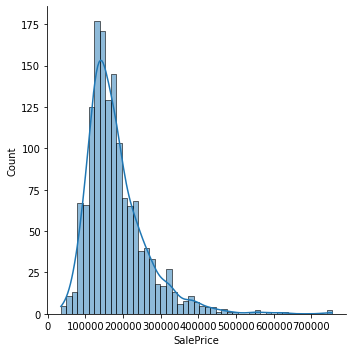

In [264]:
sns.displot(train_df['SalePrice'], kde=True)

In [265]:
# train_df[train_df[target_name] > train_df[target_name].quantile(0.995) ]

<AxesSubplot:xlabel='SalePrice'>

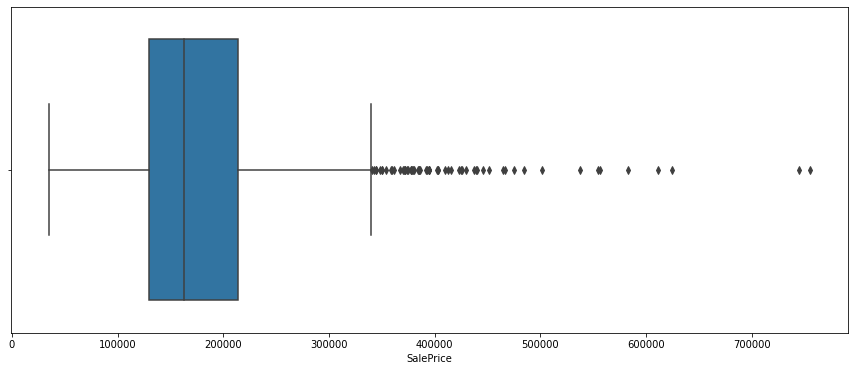

In [266]:
plt.figure(figsize=(15,6))
sns.boxplot(x = target_name, data = train_df)

На данный момент откидывать outliers не стал, поэтому попробовал сделать преобразования Бокса-Кокса

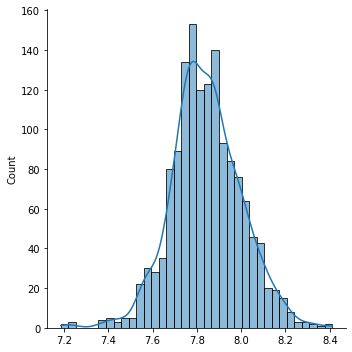

In [267]:
target_normal, boxcox_lambda = scipy.stats.boxcox(target)
sns.displot(target_normal, kde=True)

In [268]:
# scipy.special.inv_boxcox([8.4], boxcox_lambda)

#### Анализ признаков

In [313]:
float_columns = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

categorical_columns = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical',  'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

possible_categorical = ['BsmtFullBath', 'TotRmsAbvGrd' , 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageType', 'GarageCars', 'YrSold', 'MoSold',]

date_columns = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd',  ]

binary_columns = ['Street', 'CentralAir']

In [270]:
def plot_box_hist(cat):
    f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(19, 5))
    sns.boxplot(x=cat, y=target_name, data=train_df.fillna('None'), ax = a0)
    plt.setp(a0.get_xticklabels(), rotation=45)
    sns.histplot(data=train_df[cat].fillna('None').astype(str), ax = a1)
    plt.setp(a1.get_xticklabels(), rotation=45)
    f.tight_layout()
        
    rects = a1.patches
    labels = [cat.get_text() for cat in a1.get_xticklabels()]
    labels = ['{}'.format((train_df[cat].astype(str) == label).sum()) for label in labels]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        a1.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
                    ha='center', va='bottom')
                    
    plt.show()

#### Раскоментировать для прорисовки графиков

In [271]:
# with sns.plotting_context(font_scale=1.8), sns.axes_style("whitegrid"):
#     for cat in categorical_columns:
#         plot_box_hist(cat)

In [272]:
# with sns.plotting_context(font_scale=1.8), sns.axes_style("whitegrid"):
#     for cat in possible_categorical :
#         plot_box_hist(cat)

In [273]:
# with sns.plotting_context(font_scale=1.8), sns.axes_style("whitegrid"):
#     for cat in binary_columns :
#         plot_box_hist(cat)

In [274]:
# with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
#     n = len(float_columns)
#     plt.figure(figsize=(19, 5*(n+1)//2))
#     for i, col in enumerate(float_columns):
#         plt.subplot((n+1)//2, 2, i+1)
#         sns.scatterplot(x = col, y = target_name, data = train_df, )
#         sns.kdeplot(x = col, y = target_name, data = train_df, cmap = 'magma')

In [275]:
# with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
#     n = len(date_columns)
#     plt.figure(figsize=(19, 5*(n+1)//2))
#     for i, col in enumerate(date_columns):
#         plt.subplot((n+1)//2, 2, i+1)
#         sns.scatterplot(x = col, y = target_name, data = train_df, )
#         sns.kdeplot(x = col, y = target_name, data = train_df, cmap = 'magma')

Таким образом признак <b>Utilies</b> бесполезен, так как постоянен во всех случаях, кроме одного. Также малодифференцируемым признаком является <b>Street</b>  и <b>PoolQuality</b>  (и вещественный <b>Pool Area</b>  как следствие), и все те у которых количество в одной категории обладает более чем 99% всех записей.
У остальных категориальных признаков бывают такие категории, у которых очень мало присутствий в выборке. В случае самостоятельное OHE стоит учесть возможную бесполезность подобных категорий.

In [276]:
drop_columns = ['Utilities', 'PoolQC', 'PoolArea', 'Street']

#### Гипотеза о полезных признаках
1. Дата постройки сама по себе мало, что говорит об объекте. Возможно уместнее использовать возраст (или количество лет с капитального ремонта). 
2. Объединить Condition1 и Condition2 в "один общий OHE", так как там одинаковые категории

In [277]:
additional_columns = []

In [347]:
condition1_ohe_df = pd.get_dummies(train_df['Condition1']).drop(columns='Norm')
condition2_ohe_df = pd.get_dummies(train_df['Condition2']).drop(columns='Norm')
for col in condition1_ohe_df.columns:
    if col not in condition2_ohe_df.columns:
        train_df[col] = (condition1_ohe_df[col]).astype(bool)
    else:
        train_df[col] = (condition1_ohe_df[col] + condition2_ohe_df[col]).astype(bool)

condition1_ohe_df = pd.get_dummies(test_df['Condition1']).drop(columns='Norm')
condition2_ohe_df = pd.get_dummies(test_df['Condition2']).drop(columns='Norm')
for col in condition1_ohe_df.columns:
    if col not in condition2_ohe_df.columns:
        test_df[col] = (condition1_ohe_df[col]).astype(bool)
    else:
        test_df[col] = (condition1_ohe_df[col] + condition2_ohe_df[col]).astype(bool)

additional_columns.extend( condition1_ohe_df.columns)
categorical_columns.extend(condition1_ohe_df.columns)

drop_columns.extend(['Condition1', 'Condition2'])

In [279]:
# with sns.plotting_context(font_scale=1.8), sns.axes_style("whitegrid"):
#     for cat in condition1_ohe_df.columns:
#         plot_box_hist(cat)

In [346]:
train_df['AgeBuild'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['AgeBuild'] = test_df['YrSold'] - test_df['YearBuilt']
additional_columns.append('AgeBuild')

train_df['AgeRemod'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['AgeRemod'] = test_df['YrSold'] - test_df['YearRemodAdd']
additional_columns.append('AgeRemod')

float_columns.extend(['AgeBuild', 'AgeRemod'])

In [281]:
drop_columns.extend(['AgeBuild', 'AgeRemod'])

In [282]:
# with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
#     n = len(date_columns)
#     plt.figure(figsize=(19, 5*(n+1)//2))
#     for i, col in enumerate(['AgeBuild', 'AgeRemod']):
#         plt.subplot((n+1)//2, 2, i+1)
#         sns.scatterplot(x = col, y = target_name, data = train_df, )
#         sns.kdeplot(x = col, y = target_name, data = train_df, cmap = 'magma')

Наиболее полезными признаками выбрал:
<ul>
  <li>Возраст дома (Разность года покупки и постройки)</li>
  <li>Площадь подвала</li>
  <li>Площадь жилых помещений (надземных)</li>
  <li>Площадь гаража</li>
  <li>Район</li>
  <li>Площадь облицовки каменной кладкой</li>
  <li>Общее качество</li>
  <li>Общее состояние</li>
  <li>Классификация продажи</li>
</ul>

In [283]:
important_features = ['Age', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'Neighborhood', 'MasVnrArea','OverallQual', 'OverallCond', 'MSZoning' ]

In [284]:
# g = sns.pairplot(train_df[important_features+ [target_name]], diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=10, color=".2")


#### Подготовка выборки к обучению

In [344]:
encoded_df = pd.concat((train_df, test_df), axis = 0)

In [348]:
encoded_df[categorical_columns+possible_categorical+binary_columns] = encoded_df[categorical_columns+possible_categorical+binary_columns].apply(LabelEncoder().fit_transform)

In [350]:
encoded_df['SalePrice'].isna().sum()

1459

In [351]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    encoded_df[~encoded_df['SalePrice'].isna()].drop(columns =  [target_name]),
    encoded_df[~encoded_df['SalePrice'].isna()][target_name],
    test_size = 0.2,
    shuffle = True,
    random_state=2021
)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

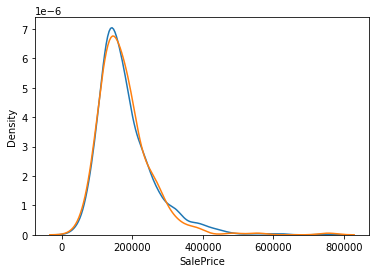

In [352]:
sns.kdeplot(train_y)
sns.kdeplot(val_y)

In [353]:
train_data = lgb.Dataset(data=train_X, label=train_y,free_raw_data=False, categorical_feature= list(set(categorical_columns+possible_categorical+binary_columns)-set(drop_columns)))
validation_data = lgb.Dataset(data=val_X, label=val_y, free_raw_data=False, reference=train_data, categorical_feature= list(set(categorical_columns+possible_categorical+binary_columns)-set(drop_columns)))

In [354]:
param = {'num_leaves': 41,  
'objective': 'regression_l1', 
'max_depth': -1,
'metric': 'rmse',
'lambda_l1': 0.1,
'learning_rate': 0.05,}

num_round = 250
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

/mnt/d/Ubuntu/Sber/aleksandrov-ds-school/ds-school-venv/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/d/Ubuntu/Sber/aleksandrov-ds-school/ds-school-venv/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/d/Ubuntu/Sber/aleksandrov-ds-school/ds-school-venv/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 81
[LightGBM] [Info] 

In [359]:
bst.predict(encoded_df[encoded_df['SalePrice'].isna()].drop(columns = target_name))

array([126097.50199932, 155722.3258018 , 184701.2095032 , ...,
       170058.45896975, 118062.79695743, 194884.72085546])

In [362]:
sample_submission['SalePrice'] = bst.predict(encoded_df[encoded_df['SalePrice'].isna()].drop(columns = target_name))

In [367]:
sample_submission.to_csv('submission.csv', index = False)